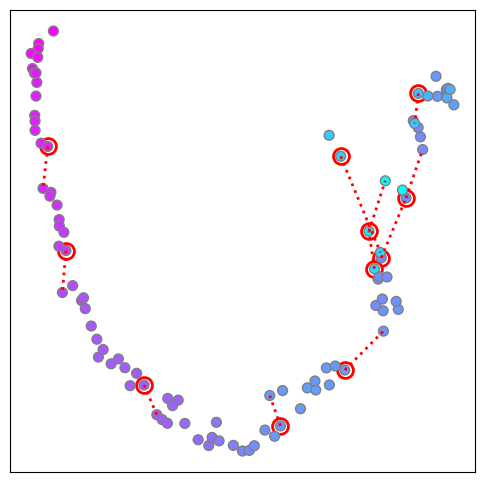

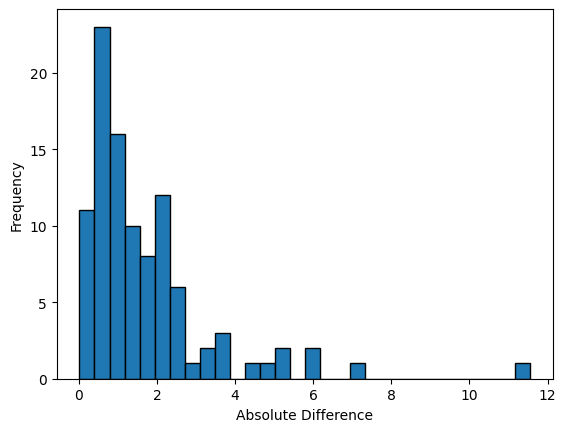

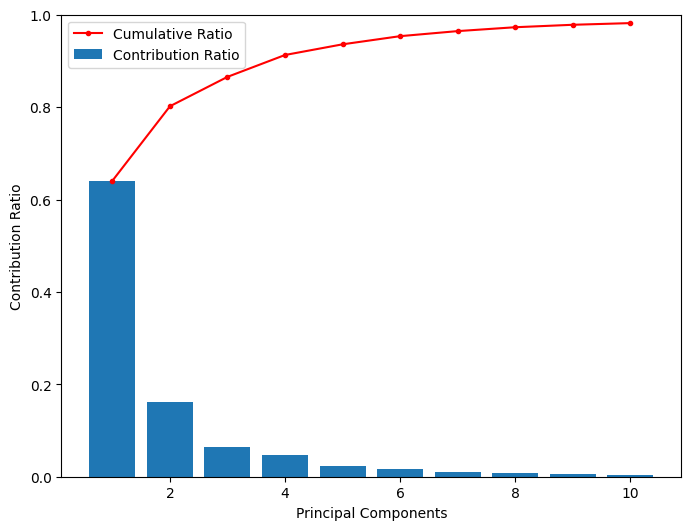

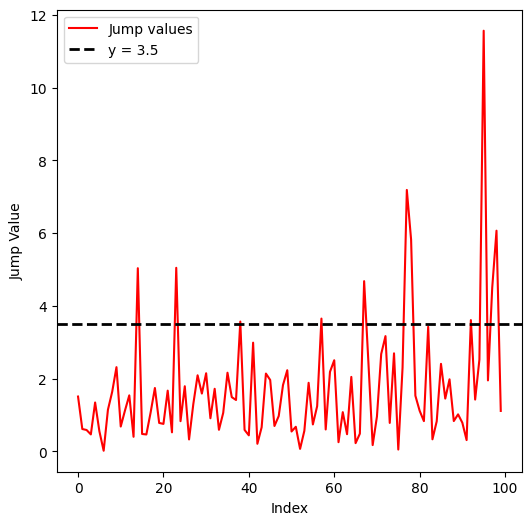

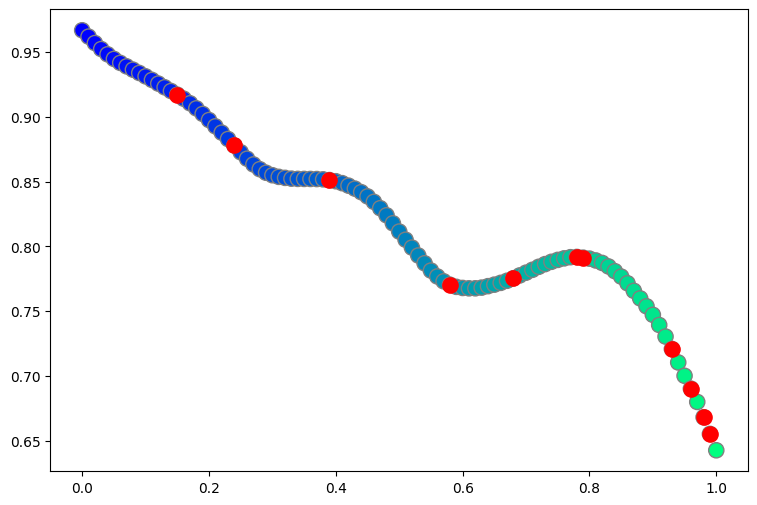

In [11]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.decomposition import PCA

def load_data(input_file):
    """Load dataset from an HDF5 file."""
    data = xr.open_dataset(input_file, engine="h5netcdf")
    return data

def preprocess_data(data):
    """Flatten and combine up/down spin data."""
    comp_list = data["Ga_comp"].values
    stacked_list = []
    
    for i in comp_list:
        up_img = data["up"].sel(Ga_comp=i).values
        down_img = data["down"].sel(Ga_comp=i).values
        stacked_list.append(np.hstack((up_img.flatten(), -down_img.flatten())))
    
    return np.vstack(stacked_list)

def perform_pca(img_data, n_components=10):
    """Perform PCA on the image data."""
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(img_data)
    return pca, pca_result

def detect_outliers(pca_result, threshold):
    """Detect outliers based on jump differences in PC2."""
    score = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
    jump_list = np.abs(np.diff(score["PC2"]))
    indices_above_threshold = np.where(jump_list > threshold)[0]
    return score, jump_list, indices_above_threshold

def plot_pca_contributions(pca):
    """Plot PCA contribution ratios and cumulative contributions."""
    contribution_ratios = pd.DataFrame(pca.explained_variance_ratio_)
    cumulative_contribution_ratios = contribution_ratios.cumsum()
    
    x_axis = range(1, len(contribution_ratios) + 1)
    plt.figure(figsize=(8, 6))
    plt.bar(x_axis, contribution_ratios.iloc[:, 0], align='center', label='Contribution Ratio')
    plt.plot(x_axis, cumulative_contribution_ratios.iloc[:, 0], 'r.-', label='Cumulative Ratio')
    plt.xlabel('Principal Components')
    plt.ylabel('Contribution Ratio')
    plt.legend()
    plt.ylim(0, 1)
    plt.show()

def plot_jump_list_vs_threshold(jump_list, threshold):
    """Plot jump values with threshold line."""
    number_list = np.arange(len(jump_list))
    plt.figure(figsize=(6, 6))
    plt.plot(number_list, jump_list, c="r", label="Jump values")
    plt.axhline(y=threshold, color="k", linestyle="--", label=f"y = {threshold}", lw=2)
    plt.xlabel('Index')
    plt.ylabel('Jump Value')
    plt.legend()
    plt.show()

def plot_spin_vs_composition(data, indices_above_threshold):
    """Plot spin polarization vs Ga composition."""
    my_list = np.linspace(0, 1, 101)
    plt.figure(figsize=(9, 6))
    plt.scatter(my_list, data["spin_polarization"], c=my_list, edgecolors="gray", cmap='winter', s=120)
    for idx in indices_above_threshold:
        plt.scatter(my_list[idx + 1], data["spin_polarization"].values[idx + 1], c="r", s=120)
    plt.show()

def plot_results(score, jump_list, indices_above_threshold, data, threshold, pca):
    """Generate various plots to visualize the PCA results and detected outliers."""
    # Scatter plot
    plt.figure(figsize=(6,6))
    for idx in indices_above_threshold:
        plt.scatter(-score['PC1'][idx], score['PC2'][idx], c="white", s=130, edgecolor='red', lw=2)
    plt.scatter(-score['PC1'], score['PC2'], c=data["spin_polarization"], cmap='cool', edgecolor='gray', s=50)
    for idx in indices_above_threshold:
        plt.plot(-score['PC1'][idx:idx+2], score['PC2'][idx:idx+2], lw=2, color="r", linestyle=":")
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
    # Histogram
    plt.hist(jump_list, bins=30, edgecolor='black')
    plt.xlabel('Absolute Difference')
    plt.ylabel('Frequency')
    plt.show()
    
    # Additional Plots
    plot_pca_contributions(pca)
    plot_jump_list_vs_threshold(jump_list, threshold)
    plot_spin_vs_composition(data, indices_above_threshold)

def main(input_file, threshold):
    """Main execution function."""
    data = load_data(input_file)
    img_data = preprocess_data(data)
    pca, pca_result = perform_pca(img_data)
    score, jump_list, indices_above_threshold = detect_outliers(pca_result, threshold)
    plot_results(score, jump_list, indices_above_threshold, data, threshold, pca)
    
# Example Usage
if __name__ == "__main__":
    INPUT_H5_PATH = "./data/save_data/h5/data.h5"
    THRESHOLD = 3.5
    main(INPUT_H5_PATH, THRESHOLD)